<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
import os

os.chdir('/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/')
!pwd

/home/iustin/Mech-Interp/Automatic-Circuit-Discovery


In [2]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running outside of colab
Running as a notebook


<h2>Imports etc</h2>

In [3]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)

from acdc.hybridretrieval.utils import (
    get_all_hybrid_retrieval_things,
    get_gpt2_small
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [4]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'hybrid-retrieval']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=hybrid-retrieval\
--zero-ablation\
--threshold=0.15\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [5]:
num_examples = 20
things = get_all_hybrid_retrieval_things(
    num_examples=num_examples, device=DEVICE, metric_name="kl_div"
)

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Clean Prompts:
Alice lives in France, Paris - Alice, John lives in Germany, Berlin - John, Peter lives in USA, Washington - Peter
Lucy lives in Turkey, Ankara - Lucy, Sara lives in Italy, Rome - Sara, Bob lives in Spain, Madrid - Bob
Tom lives in Canada, Toronto - Tom, Anna lives in Australia, Canberra - Anna, Michael lives in Japan, Tokyo - Michael
David lives in Brazil, Rio de Janeiro - David, Alice lives in France, Paris - Alice, Peter lives in Germany, Berlin - Peter
Sara lives in USA, Washington - Sara, Lucy lives in Turkey, Ankara - Lucy, Tom lives in Italy, Rome - Tom
John lives in Spain, Madrid - John, Michael lives in Canada, Toronto - Michael, Anna lives in Australia, Canberra - Anna
David lives in Japan, Tokyo - David, Sara lives in Brazil, Rio de Janeiro - Sara, Alice lives in France, Paris - Alice
Bob lives in Germany, Berlin - Bob, Peter lives in USA, Washington - Peter, Lucy lives in Turkey

In [6]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

In [7]:

# if TASK == "ioi":
#     num_examples = 100
#     things = get_all_ioi_things(
#         num_examples=num_examples, device=DEVICE, metric_name=args.metric
#     )
# elif TASK == "tracr-reverse":
#     num_examples = 6
#     things = get_all_tracr_things(
#         task="reverse",
#         metric_name=args.metric,
#         num_examples=num_examples,
#         device=DEVICE,
#     )
# elif TASK == "tracr-proportion":
#     num_examples = 50
#     things = get_all_tracr_things(
#         task="proportion",
#         metric_name=args.metric,
#         num_examples=num_examples,
#         device=DEVICE,
#     )
# elif TASK == "induction":
#     num_examples = 10
#     seq_len = 300
#     things = get_all_induction_things(
#         num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
#     )
# elif TASK == "docstring":
#     num_examples = 50
#     seq_len = 41
#     things = get_all_docstring_things(
#         num_examples=num_examples,
#         seq_len=seq_len,
#         device=DEVICE,
#         metric_name=args.metric,
#         correct_incorrect_wandb=True,
#     )
# elif TASK == "greaterthan":
#     num_examples = 100
#     things = get_all_greaterthan_things(
#         num_examples=num_examples, metric_name=args.metric, device=DEVICE
#     )
# else:
#     raise ValueError(f"Unknown task {TASK}")

<p> Let's define the four most important objects for ACDC experiments:

In [7]:
validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

In [8]:
second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

<h2>Setup ACDC Experiment</h2>

In [9]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:139: UserWarning:

We shall overwrite the ref_ds with zeros.



dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 32613
New metric: 1.3947685956954956
No edge 32613
No edge 32613
No edge 32613
We moved to  blocks.11.attn.hook_v[:, :, 11]
No edge 32613
No edge 32612
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 10]
No edge 32612
No edge 32611
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 9]
No edge 32611
No edge 32610
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 8]
No edge 32610
No edge 32609
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 7]
No edge 32609
No edge 32608
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 6]
No edge 32608
No edge 32607
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 5]
No edge 32607
No edge 32606
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 4]
No edge 32606
No edge 32605
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 3]
No edge 32605
No edge 32604
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 2]
No edge 32604
No edge 32603
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 1]
No edge 32603
No 

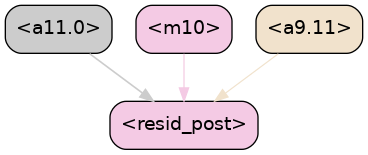

0 --------------------------------------------------
No edge 32602
32602
No edge 32602
New metric: 1.3947685956954956

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.11.hook_v_input [:, :, 0] is 1.511886477470398 (and current metric 1.3947685956954956)
Result is 0.11711788177490234...so removing connection
No edge 32601
We moved to  blocks.11.attn.hook_k[:, :, 11]
No edge 32601
No edge 32600
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 10]
No edge 32600
No edge 32599
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 9]
No edge 32599
No edge 32598
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 8]
No edge 32598
No edge 32597
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 7]
No edge 32597
No edge 32596
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 6]
No edge 32596
No edge 32595
But it's bad
We moved to  blocks.11.attn.h

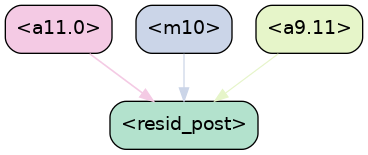

1 --------------------------------------------------
No edge 32590
32590
No edge 32590
New metric: 1.511886477470398

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.11.hook_k_input [:, :, 0] is 1.511886477470398 (and current metric 1.511886477470398)
Result is 0.0...so removing connection
No edge 32589
We moved to  blocks.11.attn.hook_q[:, :, 11]
No edge 32589
No edge 32588
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 10]
No edge 32588
No edge 32587
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 9]
No edge 32587
No edge 32586
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 8]
No edge 32586
No edge 32585
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 7]
No edge 32585
No edge 32584
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 6]
No edge 32584
No edge 32583
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 5]
No 

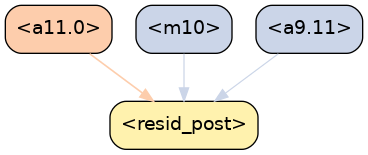

2 --------------------------------------------------
No edge 32578
32578
No edge 32578
New metric: 1.511886477470398

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.11.hook_q_input [:, :, 0] is 1.511886477470398 (and current metric 1.511886477470398)
Result is 0.0...so removing connection
No edge 32577
We moved to  blocks.11.hook_v_input[:, :, 11]
No edge 32577
No edge 32433
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 10]
No edge 32433
No edge 32289
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 9]
No edge 32289
No edge 32145
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 8]
No edge 32145
No edge 32001
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 7]
No edge 32001
No edge 31857
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 6]
No edge 31857
No edge 31713
But it's bad
We moved to  blocks.11.hook_v_input[:, :,

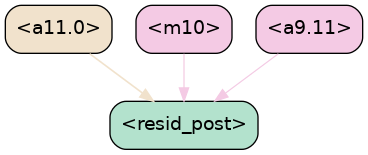

3 --------------------------------------------------
No edge 27393
27393
No edge 27393
New metric: 1.511886477470398
No edge 27393
We moved to  blocks.10.hook_mlp_in[:]
No edge 27393


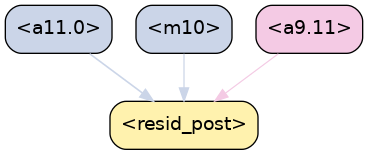

4 --------------------------------------------------
No edge 27393
27393
No edge 27393
New metric: 1.511886477470398

Node: cur_parent=TLACDCInterpNode(blocks.10.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.10.hook_mlp_in, [:]))

Metric after removing connection to blocks.10.attn.hook_result [:, :, 0] is 1.4941773414611816 (and current metric 1.511886477470398)
Result is -0.01770913600921631...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.10.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.10.hook_mlp_in, [:]))

Metric after removing connection to blocks.10.attn.hook_result [:, :, 1] is 1.4941353797912598 (and current metric 1.4941773414611816)
Result is -4.1961669921875e-05...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.10.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.10.hook_mlp_in, [:]))

Metric after removing connection to blocks.10.attn.hook_result [:, :, 2] is 1.4899

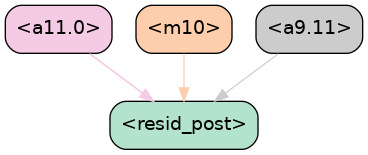

5 --------------------------------------------------
No edge 22368
22368
No edge 22368
New metric: 2.5835559368133545
No edge 22368
No edge 22368
No edge 22368
We moved to  blocks.9.attn.hook_result[:, :, 10]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 9]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 8]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 7]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 6]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 5]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 4]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 3]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 2]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result

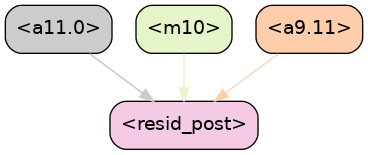

6 --------------------------------------------------
No edge 22368
22368
No edge 22368
New metric: 2.5835559368133545

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 11]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_v, [:, :, 11]))

Metric after removing connection to blocks.9.hook_v_input [:, :, 11] is 5.390759468078613 (and current metric 2.5835559368133545)
Result is 2.807203531265259...so keeping connection
No edge 22368
We moved to  blocks.9.attn.hook_v[:, :, 10]
No edge 22368
No edge 22367
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 9]
No edge 22367
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 8]
No edge 22366
No edge 22365
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 7]
No edge 22365
No edge 22364
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 6]
No edge 22364
No edge 22363
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 5]
No edge 22363
No edge 22362
But it's bad
We moved to  blocks.9.attn.hook_v[:, :,

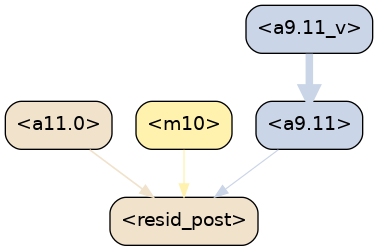

7 --------------------------------------------------
No edge 22357
22357
No edge 22357
New metric: 2.5835559368133545

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 11]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_k, [:, :, 11]))

Metric after removing connection to blocks.9.hook_k_input [:, :, 11] is 4.4629106521606445 (and current metric 2.5835559368133545)
Result is 1.87935471534729...so keeping connection
No edge 22357
We moved to  blocks.9.attn.hook_k[:, :, 10]
No edge 22357
No edge 22356
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 9]
No edge 22356
No edge 22355
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 8]
No edge 22355
No edge 22354
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 7]
No edge 22354
No edge 22353
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 6]
No edge 22353
No edge 22352
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 5]
No edge 22352
No edge 22351
But it's bad
We moved to  blocks.9.attn.hook_k[:, :,

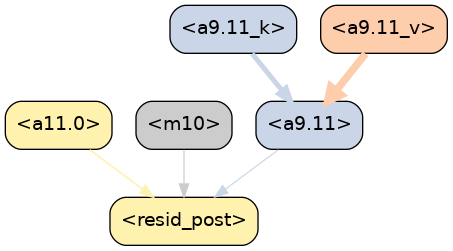

8 --------------------------------------------------
No edge 22346
22346
No edge 22346
New metric: 2.5835559368133545

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 11]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_q, [:, :, 11]))

Metric after removing connection to blocks.9.hook_q_input [:, :, 11] is 4.814820289611816 (and current metric 2.5835559368133545)
Result is 2.231264352798462...so keeping connection
No edge 22346
We moved to  blocks.9.attn.hook_q[:, :, 10]
No edge 22346
No edge 22345
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 9]
No edge 22345
No edge 22344
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 8]
No edge 22344
No edge 22343
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 7]
No edge 22343
No edge 22342
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 6]
No edge 22342
No edge 22341
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 5]
No edge 22341
No edge 22340
But it's bad
We moved to  blocks.9.attn.hook_q[:, :,

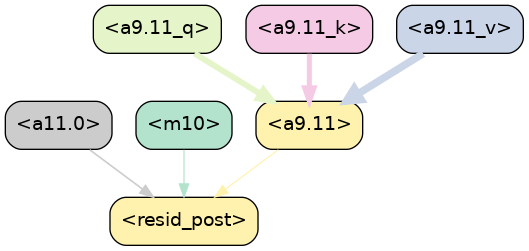

9 --------------------------------------------------
No edge 22335
22335
No edge 22335
New metric: 2.5835559368133545

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 11]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 2.6422295570373535 (and current metric 2.5835559368133545)
Result is 0.05867362022399902...so removing connection
No edge 22334

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 2.6568336486816406 (and current metric 2.6422295570373535)
Result is 0.01460409164428711...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] 

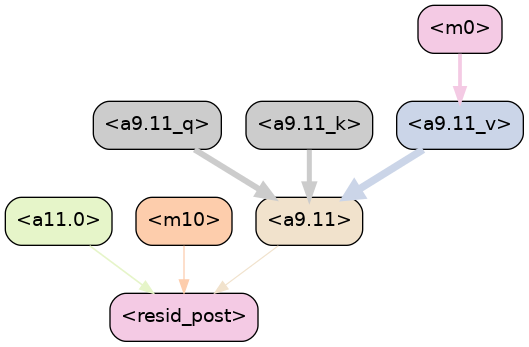

10 --------------------------------------------------
No edge 20920
20920
No edge 20920
New metric: 2.906942129135132

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 11]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 2.883314847946167 (and current metric 2.906942129135132)
Result is -0.023627281188964844...so removing connection
No edge 20919

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 2.8827130794525146 (and current metric 2.883314847946167)
Result is -0.0006017684936523438...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1

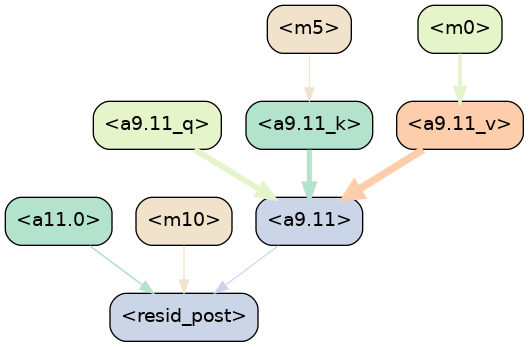

11 --------------------------------------------------
No edge 19505
19505
No edge 19505
New metric: 4.4852118492126465

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 11]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 4.49727201461792 (and current metric 4.4852118492126465)
Result is 0.012060165405273438...so removing connection
No edge 19504

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 4.487740516662598 (and current metric 4.49727201461792)
Result is -0.009531497955322266...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 11]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] i

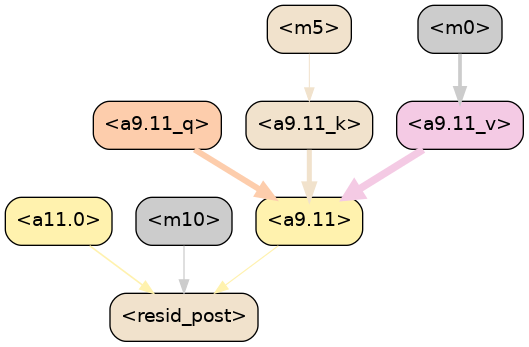

12 --------------------------------------------------
No edge 7733
7733
No edge 7733
New metric: 4.749383926391602
No edge 7733
We moved to  blocks.5.hook_mlp_in[:]
No edge 7733


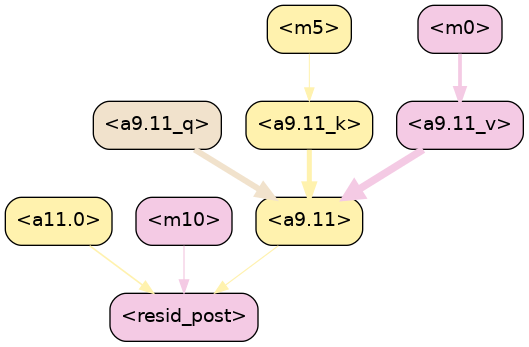

13 --------------------------------------------------
No edge 7733
7733
No edge 7733
New metric: 4.749383926391602

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 0] is 4.749569892883301 (and current metric 4.749383926391602)
Result is 0.00018596649169921875...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 1] is 4.7494025230407715 (and current metric 4.749569892883301)
Result is -0.00016736984252929688...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 2] is 4.749543666839

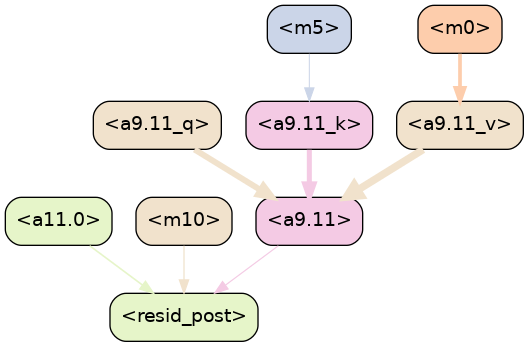

14 --------------------------------------------------
No edge 93
93
No edge 93
New metric: 4.861042022705078
No edge 93
We moved to  blocks.0.hook_mlp_in[:]
No edge 93


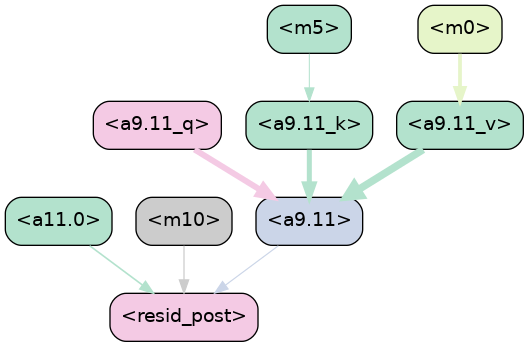

15 --------------------------------------------------
No edge 93
93
No edge 93
New metric: 4.861042022705078

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 4.847009181976318 (and current metric 4.861042022705078)
Result is -0.014032840728759766...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 4.91026496887207 (and current metric 4.847009181976318)
Result is 0.06325578689575195...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 4.849630355834961 (and curr

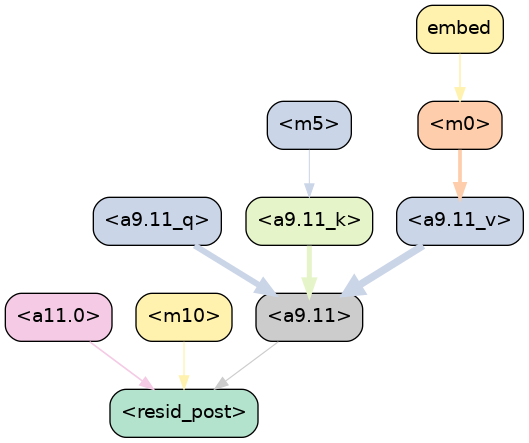

16 --------------------------------------------------
No edge 9
9
No edge 9
New metric: 4.734110355377197
We moved to  None
No edge 9


/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:772: UserWarning:

Finished iterating



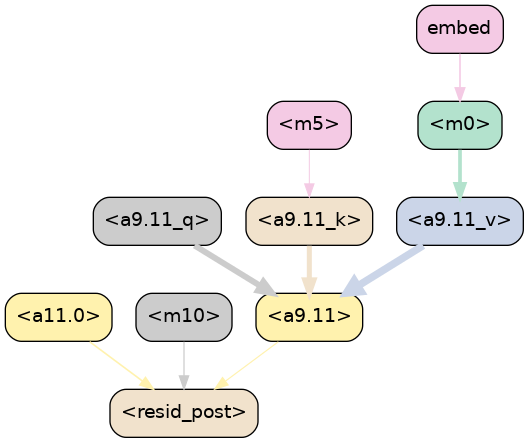

17 --------------------------------------------------
No edge 9
9


In [12]:
import datetime
exp_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
start_time = datetime.datetime.now()  # Record the start time

# Define the save path
save_path = "acdc/hybridretrieval/acdc_results/ims_hybridretrieval_indirect_0.15_test"

for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"{save_path}/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"{save_path}/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges(f"{save_path}/edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        show(
            exp.corr,
            f"{save_path}/ACDC_img_{exp_time}.png",

        )
        break

# Calculate elapsed time
elapsed_time = datetime.datetime.now() - start_time
print(f"Elapsed time: {elapsed_time}")

exp.save_edges(f"{save_path}/another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"{save_path}/edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()
else:   
    edges_fname = f"{save_path}/edges.pth"
    exp.save_edges(edges_fname)

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [13]:
exp.save_subgraph(
    save_path=save_path,
    return_it=True,
)

OrderedDict([(('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 0)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.10.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.9.attn.hook_result',
               (None, None, 11)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 0),
               'blocks.11.attn.hook_q',
               (None, None, 0)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 0),
               'blocks.11.attn.hook_k',
               (None, None, 0)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 0),
               'blocks.11.attn.hook_v',
               (None, None, 0)),
              True)

: 

In [10]:
# load using torch
save_path = "acdc/hybridretrieval/acdc_results/ims_hybridretrieval_indirect_0.15_test"
subgraph_path = f"{save_path}/edges.pth"
circuit = torch.load(subgraph_path)
circuit

OrderedDict([(('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 8)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 0)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.10.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.0.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 8),
               'blocks.11.attn.hook_q',
               (None, None, 8)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 8),
               'blocks.11.attn.hook_k',
               (None, None, 8)),
              True),
             ((

In [11]:
from collections import OrderedDict

# Define a helper function to create a hashable tuple
def hashable_tuple(t):
    if isinstance(t, (list, tuple)):
        return tuple(hashable_tuple(i) for i in t)
    return t

# Assuming `exp` is your experiment object and `circuit` is your OrderedDict

# List all required edges (keys)
required_keys = exp.corr.all_edges().keys()

# Initialize an empty OrderedDict for the updated circuit
updated_circuit = OrderedDict()

# Add missing keys with a default value (e.g., True)
for key in required_keys:
    receiver_name, receiver_torch_index, sender_name, sender_torch_index = key
    new_key = (receiver_name, receiver_torch_index.hashable_tuple, sender_name, sender_torch_index.hashable_tuple)
    updated_circuit[new_key] = circuit.get(new_key, True)

# Load the subgraph with the updated circuit
exp.load_subgraph(updated_circuit)

Editing all edges...
Done!


In [12]:
updated_circuit

OrderedDict([(('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 11)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 10)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 9)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 8)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 7)),
              True),
        

In [13]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch

# Initialize the HookedTransformer model
model = HookedTransformer.from_pretrained('gpt2-small')

# Ensure the state dictionary is properly formatted
state_dict = updated_circuit  # updated_dict should be your properly formatted state dict

# Load the state dictionary into the model
model.load_and_process_state_dict(state_dict)

# Verify that the state_dict is loaded correctly
model.eval()  # Set the model to evaluation mode

Loaded pretrained model gpt2-small into HookedTransformer


KeyError: 'blocks.0.ln1.b'

In [15]:
kwargs = dict(**things.tl_model.cfg.__dict__)
for kwarg_string in [
    "use_split_qkv_input",
    "n_devices",
    "gated_mlp",
    "use_attn_in",
    "use_hook_mlp_in",
    "default_prepend_bos",
    "dtype",
    "add_special_tokens",
]:
    if kwarg_string in kwargs:
        del kwargs[kwarg_string]

cfg = HookedTransformerConfig(**kwargs)
model = HookedTransformer(cfg)

tl_model = things.tl_model
model.load_state_dict(tl_model.state_dict(), strict=False)

<All keys matched successfully>

In [25]:
tl_model.state_dict()

OrderedDict([('embed.W_E',
              tensor([[-0.1106, -0.0398,  0.0326,  ..., -0.1369,  0.0146,  0.0448],
                      [ 0.0359, -0.0531,  0.0418,  ...,  0.0816, -0.0019,  0.0387],
                      [-0.1301,  0.0453,  0.1815,  ...,  0.0873, -0.1324, -0.0905],
                      ...,
                      [-0.0447, -0.0550,  0.0121,  ...,  0.1042,  0.0976, -0.0697],
                      [ 0.1870,  0.0176,  0.0471,  ..., -0.0953,  0.0795, -0.0215],
                      [ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210]],
                     device='cuda:0')),
             ('pos_embed.W_pos',
              tensor([[-1.3368e-02, -1.9197e-01,  9.4797e-03,  ..., -3.7591e-02,
                        3.3720e-02,  5.9943e-02],
                      [ 2.4966e-02, -5.2785e-02, -9.3872e-02,  ...,  3.5177e-02,
                        1.1178e-02,  8.5082e-04],
                      [ 6.4541e-03, -8.2526e-02,  5.6753e-02,  ...,  2.1983e-02,
                        2

In [27]:
circuit

OrderedDict([(('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 8)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.11.attn.hook_result',
               (None, None, 0)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.10.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.hook_resid_post',
               (None,),
               'blocks.0.hook_mlp_out',
               (None,)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 8),
               'blocks.11.attn.hook_q',
               (None, None, 8)),
              True),
             (('blocks.11.attn.hook_result',
               (None, None, 8),
               'blocks.11.attn.hook_k',
               (None, None, 8)),
              True),
             ((

In [24]:
model.load_state_dict(circuit, strict=False)

AttributeError: 'tuple' object has no attribute 'startswith'